# **References**



---


---

Reference Papers:


*   Sequence to Sequence Learning with Neural Networks [[link](https://arxiv.org/abs/1409.3215)]
*   iNLTK: Natural Language Toolkit for Indic Languages [[link](https://arxiv.org/abs/2009.12534)]
*   Learning Phrase Representations using RNN Encoder-Decoder [[link](https://arxiv.org/abs/1406.1078)]
*   "A Passage to India": Pre-trained Word Embeddings for Indian Languages [[link](https://www.aclweb.org/anthology/2020.sltu-1.49.pdf)]
*   Neural Machine Translation by Jointly Learning to Align and Translate [[link](https://arxiv.org/abs/1409.0473)]




Reference Tutorials:

*   How to use Pre-trained Word Embeddings in PyTorch [[link](https://medium.com/@martinpella/how-to-use-pre-trained-word-embeddings-in-pytorch-71ca59249f76)]
*   Mechanics of Seq2seq Models With Attention [[link](https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/)]






Reference for Code: [Pytorch Tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)

# **Setup**

---




*   Connect with Gdrive.
*   Download and load libraries/packages.

In [ ]:
SOS_token = 0
EOS_token = 1
UKN_token = 2
MAX_LENGTH = 500
teacher_forcing_ratio = 1
N_Epochs = 3
NUM_LAYERS = 1

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
%cd gdrive/MyDrive/CS779:\ Competition

/content/gdrive/MyDrive/CS779: Competition


In [ ]:
import numpy as np
import pandas as pd

import time
import math
import random

import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

In [ ]:
%matplotlib inline

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on =", device)

Running on = cuda


Setup SpaCy

---



In [ ]:
!python3 -m spacy download en >> /dev/null

In [ ]:
import spacy
eng = spacy.load("en_core_web_sm")

Setup indicnlp library

---



In [ ]:
#### Ony run to download the indic library (first time only) 
# !git clone https://github.com/anoopkunchukuttan/indic_nlp_library >> /dev/null
# !git clone https://github.com/anoopkunchukuttan/indic_nlp_resources.git >> /dev/null

In [ ]:
!pip install Morfessor >> /dev/null

In [ ]:
# The path to the local git repo for Indic NLP library
INDIC_NLP_LIB_HOME = "indic_nlp_library"

# The path to the local git repo for Indic NLP Resources
INDIC_NLP_RESOURCES = "indic_nlp_resources"

# Add Library to Python path
import sys
sys.path.append(r"{}".format(INDIC_NLP_LIB_HOME))

# Set environment variable
from indicnlp import common
common.set_resources_path(INDIC_NLP_RESOURCES)

# Initialize the Indic NLP library
from indicnlp import loader
loader.load()

In [ ]:
from indicnlp.normalize.indic_normalize import IndicNormalizerFactory

Setup iNLTK library

---



In [ ]:
!pip install inltk >> /dev/null

In [ ]:
from inltk.inltk import setup
'''
Note: Run setup('<code-of-language>') to a language for the FIRST TIME ONLY.
This will download all the necessary models required to do inference for that language.
'''
try:
    setup("hi")
except:
    print("Downloading 'hindi' setup... Wait before running next cell!")

In [ ]:
from inltk.inltk import tokenize as inltk_tokenize

Setup NLTK library - For evaluation

---



In [ ]:
!pip install -U nltk >> /dev/null

In [ ]:
import nltk
nltk.download('wordnet')

from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import single_meteor_score

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# **Load Data**


---



*   Load training data
*   Load Embedding matrix, word2index and index2word for Hindi








In [ ]:
df = pd.read_csv("train/train.csv")
df = df[["hindi", "english"]]
display(df.head(5))
print("\nTotal hindi-english sentence pairs = ", df.shape[0])

,hindi,english
0,"एल सालवाडोर मे, जिन दोनो पक्षों ने सिविल-युद्ध...","In El Salvador, both sides that withdrew from ..."
1,मैं उनके साथ कोई लेना देना नहीं है.,I have nothing to do with them.
2,-हटाओ रिक.,"Fuck them, Rick."
3,क्योंकि यह एक खुशियों भरी फ़िल्म है.,Because it's a happy film.
4,The thought reaching the eyes...,The thought reaching the eyes...



Total hindi-english sentence pairs =  102322


In [ ]:
# #####################################################################
# #### Testing on smaller data
# #####################################################################
# df = df[:500]

In [ ]:
my_embeddings = np.load("hindi_embeddings.npy")
word2index_npy = np.load("word2index.npy")
index2word_npy = np.load("index2word.npy")

In [ ]:
hindi_word2index = {}
hindi_index2word = {}

for i in range(len(word2index_npy)):
    hindi_word2index[word2index_npy[i, 0]] = int(word2index_npy[i, 1])

for i in range(len(index2word_npy)):
    hindi_index2word[int(index2word_npy[i, 0])] = index2word_npy[i, 1]

# **Data Normalisation and Pre-processing**

---

*   Remove nuktas from Hindi sentences.
*   Create **embedding matrix** using iNLTK library.





In [ ]:
factory = IndicNormalizerFactory()
normalizer = factory.get_normalizer("hi", remove_nuktas = True)

for i, pair in df.iterrows():
    df.iloc[i, 0] = normalizer.normalize(pair[0])

    if(i != 0 and i%10000 == 0):
        print("Iterations done =", i)
print("...Done")

Iterations done = 10000
Iterations done = 20000
Iterations done = 30000
Iterations done = 40000
Iterations done = 50000
Iterations done = 60000
Iterations done = 70000
Iterations done = 80000
Iterations done = 90000
Iterations done = 100000
...Done


In [ ]:
class Language:
    def __init__(self, name):
        self.name = name
        if (name == "english"):
            self.n_words = 3  # UKN, SOS and EOS
            self.word2index = {"<sos>":0, "<eos>":1, "<ukn>":2}
            self.index2word = {0: "<sos>", 1: "<eos>", 2: "<ukn>"}
        elif (name == "hindi"):
            self.n_words = len(hindi_word2index)
            self.word2index = hindi_word2index
            self.index2word = hindi_index2word

    def addSentence(self, sentence):
        if (self.name == "english"):
            tokens = eng(sentence)
            for token in tokens:
                self.addWord(token.text)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.index2word[self.n_words] = word
            self.n_words += 1

In [ ]:
def readData():
    print("Reading data...")
    pairs = [[sent for sent in pair] for _, pair in df.iterrows()]
    input_lang = Language("hindi")
    output_lang = Language("english")

    # print("Data normalisation...")
    #############################################################################
    ### Add normalising techniques
    #############################################################################

    print("Data preprocessing...")
    for i, pair in enumerate(pairs):
        output_lang.addSentence(pair[1])

        if(i != 0 and i%10000 == 0):
            print("Iterations done = ", i)
    print("... Done")

    return input_lang, output_lang, pairs

In [ ]:
input_lang, output_lang, pairs = readData()

Reading data...
Data preprocessing...


# **Utility Functions**

---



In [ ]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base = 0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show();

The below cell has utility functions to return a pair of input-ouput tensor.

---



In [ ]:
def indexesFromSentence(lang, sentence):
    idx_list = []
    if (lang.name == "english"):
        tokens = eng(sentence)
        for token in tokens:
            if token.text in lang.word2index:
                idx_list.append(lang.word2index[token.text])
            else:
                idx_list.append(UKN_token)
    else:
        tokens = inltk_tokenize(sentence, "hi")
        for token in tokens:
                if token in lang.word2index:
                    idx_list.append(lang.word2index[token])
                else:
                    idx_list.append(UKN_token)
    idx_list.append(EOS_token)
    return idx_list

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    return torch.tensor(indexes, dtype = torch.long, device = device).view(-1, 1)

def tensorsFromPair(pair):
    return (tensorFromSentence(input_lang, pair[0]), tensorFromSentence(output_lang, pair[1]))

Split the training data into Train-Validation split. Half the validation data is used as Test data.

---



In [ ]:
#Temporary data
data = np.reshape(np.random.randn(2*df.shape[0]),(df.shape[0], 2))
labels = np.random.randint(2, size = df.shape[0])
X = pd.DataFrame(data, columns = ['Column_1', 'Column_2'])
y = pd.Series(labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)

In [ ]:
train_indexes = list(X_train.index)
test_indexes = list(X_test.index)

test_df = df.iloc[test_indexes]
train_df = df.iloc[train_indexes]

### The below lines 
# validation_pairs = [tensorsFromPair(list(test_df.iloc[i])) for i in range(test_df.shape[0])]
# train_pairs = [[sent for sent in pair] for _, pair in train_df.iterrows()]
# train_pairs = [tensorsFromPair(train_pairs[idx]) for idx in range(len(train_pairs))]

validation_pairs = torch.load("val.pt")
test_pairs = validation_pairs[int(len(validation_pairs)/2):]
validation_pairs = validation_pairs[:int(len(validation_pairs)/2)]
train_pairs = torch.load("train.pt")

In [ ]:
def inputData(n_iter):
    idx = int((n_iter - 1) - train_df.shape[0]*int((n_iter - 1)/train_df.shape[0]))
    train = train_pairs[idx]
    return train

In [ ]:
class EarlyStopping:
    def __init__(self, patience = 10, verbose = True):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, encoder, decoder):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, encoder, decoder)
        elif score < self.best_score:
            self.counter += 1
            print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, encoder, decoder)
            self.counter = 0

    def save_checkpoint(self, val_loss, encoder, decoder):
        '''Saves model when loss decrease.'''
        if self.verbose:
            print(f"Validation loss decreased ({self.val_loss_min:.5f} --> {val_loss:.5f}).  Saving model ...\n")
        torch.save(encoder.state_dict(), "encoder_bestVal.pt")
        torch.save(decoder.state_dict(), "decoder_bestVal.pt")
        self.val_loss_min = val_loss

# **Model**

---



In [ ]:
class Encoder(nn.Module):
    def __init__(self, hidden_size, input_vocab = input_lang.n_words, emb_size = 400):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_vocab, emb_size)
        self.embedding.from_pretrained(torch.from_numpy(my_embeddings), freeze = True)
        self.gru = nn.GRU(emb_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device = device)

In [ ]:
class AttnDecoder(nn.Module):
    def __init__(self, hidden_size, emb_size = 400, output_vocab = output_lang.n_words, max_length = MAX_LENGTH):
        super(AttnDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_vocab = output_vocab
        self.max_length = max_length
        self.emb_size = emb_size

        self.embedding = nn.Embedding(self.output_vocab, self.emb_size)
        self.attn = nn.Linear((self.hidden_size + self.emb_size), self.max_length)
        self.attn_combine = nn.Linear((self.hidden_size + self.emb_size), self.hidden_size)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_vocab)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)

        attn_weights = self.attn(torch.cat((embedded[0], hidden[0]), dim = 1))
        attn_weights = F.softmax(attn_weights, dim = 1)

        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), dim = 1)
        output = self.attn_combine(output).unsqueeze(0)
        output = F.relu(output)

        output, hidden = self.gru(output, hidden)
        output = F.log_softmax(self.out(output[0]), dim = 1)

        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device = device)

# **Train**

---



In [ ]:
LOSS_FXN = nn.NLLLoss()

In [ ]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, loss_fxn, max_length = MAX_LENGTH):
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    encoder_hidden = encoder.initHidden()
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device = device)

    loss = 0
    for ei in range(min(input_length, max_length)):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device = device)
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            loss +=  loss_fxn(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            loss +=  loss_fxn(decoder_output, target_tensor[di])

            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()
            if decoder_input.item() == EOS_token:
                break

    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item()/target_length

In [ ]:
def validate(validation_pairs, encoder, decoder, loss_fxn, max_length = MAX_LENGTH):
    with torch.no_grad():
        val_loss = 0

        for i in range(len(validation_pairs)):
            input_tensor = validation_pairs[i][0]
            target_tensor = validation_pairs[i][1]

            input_length = input_tensor.size(0)
            target_length = target_tensor.size(0)

            encoder_hidden = encoder.initHidden()
            encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device = device)

            loss = 0
            for ei in range(min(input_length, max_length)):
                encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
                encoder_outputs[ei] = encoder_output[0, 0]

            decoder_input = torch.tensor([[SOS_token]], device = device)
            decoder_hidden = encoder_hidden

            for di in range(target_length):
                decoder_output, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_outputs)
                topv, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze().detach()

                loss +=  loss_fxn(decoder_output, target_tensor[di])
                if decoder_input.item() == EOS_token:
                    break

        val_loss += loss.item()/target_length

    return val_loss

In [ ]:
def trainIters(encoder, decoder, n_iters = 0, print_every = 1000, plot_every = 100, val_every = 1, learning_rate = 0.01):
    print_loss_total = 0
    plot_loss_total = 0
    min_loss = np.Inf
    plot_losses = []

    encoder_optimizer = optim.SGD(encoder.parameters(), lr = learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr = learning_rate)

    loss_fxn = LOSS_FXN
    early_stopping = EarlyStopping(patience = 3, verbose = True)

    for iter in range(1, n_iters + 1):
        training_pair = inputData(iter)

        input_tensor = training_pair[0].to(device)
        target_tensor = training_pair[1].to(device)

        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, loss_fxn)
        print_loss_total += loss
        plot_loss_total += loss

        if (iter%print_every) == 0:
            print_loss_avg = print_loss_total/print_every
            print_loss_total = 0
            print("Iterations: %d (%d%%)\nLoss = %.4f\n" %(iter, iter/n_iters*100, print_loss_avg))

            if (print_loss_avg <= min_loss):
                min_loss = print_loss_avg
                torch.save(encoder.state_dict(), "encoder_bestTrain.pt")
                torch.save(decoder.state_dict(), "decoder_bestTrain.pt")

        if (iter%plot_every) == 0:
            plot_loss_avg = plot_loss_total/plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

        if (iter%val_every) == 0:
            val_loss = validate(validation_pairs, encoder, decoder, loss_fxn)
            print("Validate loss = ", val_loss)
            early_stopping(val_loss, encoder, decoder)        
            if early_stopping.early_stop:
                print("Early stopping...")
                break
        
    torch.save(encoder.state_dict(), "encoder_final.pt")
    torch.save(decoder.state_dict(), "decoder_final.pt")
    showPlot(plot_losses)

In [ ]:
hidden_size = 512
encoder = Encoder(hidden_size).to(device)
decoder = AttnDecoder(hidden_size).to(device)

Iterations: 10000 (3%)
Loss = 5.1993

Iterations: 20000 (7%)
Loss = 4.4842

Iterations: 30000 (10%)
Loss = 4.1746

Iterations: 40000 (14%)
Loss = 4.0153

Iterations: 50000 (18%)
Loss = 3.8777

Validate loss =  4.584026336669922
Validation loss decreased (inf --> 4.58403).  Saving model ...

Iterations: 60000 (21%)
Loss = 3.7739

Iterations: 70000 (25%)
Loss = 3.7603

Iterations: 80000 (28%)
Loss = 3.6980

Iterations: 90000 (32%)
Loss = 3.6663

Iterations: 100000 (36%)
Loss = 3.5575

Validate loss =  7.636861801147461
EarlyStopping counter: 1 out of 3
Iterations: 110000 (39%)
Loss = 3.5435

Iterations: 120000 (43%)
Loss = 3.4372

Iterations: 130000 (47%)
Loss = 3.3904

Iterations: 140000 (50%)
Loss = 3.3573

Iterations: 150000 (54%)
Loss = 3.2812

Validate loss =  6.589169502258301
EarlyStopping counter: 2 out of 3
Iterations: 160000 (57%)
Loss = 3.3056

Iterations: 170000 (61%)
Loss = 3.2915

Iterations: 180000 (65%)
Loss = 3.2941

Iterations: 190000 (68%)
Loss = 3.2661

Iterations: 20

<Figure size 432x288 with 0 Axes>

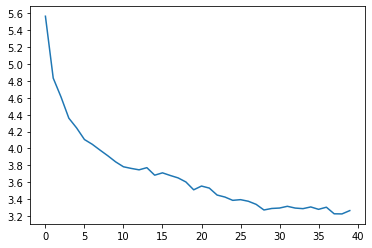

In [ ]:
trainIters(encoder, decoder, n_iters = N_Epochs*train_df.shape[0], print_every = 10000, plot_every = 5000, val_every = 50000)

# **Evaluation**

---



In [ ]:
def test(test_pairs, encoder, decoder, loss_fxn, max_length = MAX_LENGTH):
    with torch.no_grad():
        test_loss = 0

        for i in range(len(test_pairs)):
            input_tensor = test_pairs[i][0]
            target_tensor = test_pairs[i][1]

            input_length = input_tensor.size(0)
            target_length = target_tensor.size(0)

            encoder_hidden = encoder.initHidden()
            encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device = device)

            loss = 0
            for ei in range(min(input_length, max_length)):
                encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
                encoder_outputs[ei] = encoder_output[0, 0]

            decoder_input = torch.tensor([[SOS_token]], device = device)
            decoder_hidden = encoder_hidden

            for di in range(target_length):
                decoder_output, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_outputs)
                topv, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze().detach()

                loss +=  loss_fxn(decoder_output, target_tensor[di])
                if decoder_input.item() == EOS_token:
                    break
                    
        test_loss += loss.item()/target_length

    return test_loss

In [ ]:
test(test_pairs, encoder, decoder, LOSS_FXN)

10.036038208007813

In [ ]:
def evaluate(encoder, decoder, sentence, max_length = MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size(0)
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device = device)

        for ei in range(min(input_length, max_length)):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] = encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device = device)
        decoder_hidden = encoder_hidden

        decoded_words = []
        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()
            if topi.item() == EOS_token:
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

        return decoded_words

In [ ]:
def evaluateRandomly(encoder, decoder, n = 100):
    total_bleu_scores = 0
    total_meteor_scores = 0

    for i in range(n):
        pair = random.choice(pairs)
        print('INPUT: ', pair[0])
        print('TARGET: ', pair[1])
        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('PRED: ', output_sentence)
        total_bleu_scores += sentence_bleu(pair[1].split(" "), output_sentence.split(" "))
        total_meteor_scores += single_meteor_score(pair[1], output_sentence)
        print('')

    bleu_result = total_bleu_scores/n
    meteor_result = total_meteor_scores/n
    print("\n\nbleu score: ",bleu_result)
    print("meteor score: ",meteor_result)

In [ ]:
evaluateRandomly(encoder, decoder, n = 10)

INPUT:  लेकिन यह मेरे दिमाग में अप्रमाणित है.
TARGET:  But this is unproven in my mind.
PRED:  But this is a very important part of me .

INPUT:  जब आप कोबरा कमांडर को खोजने के लिए.
TARGET:  For when you find Cobra Commander.
PRED:  When you find the rest of the old man for you .

INPUT:  फिल, वे मेरे क्रेडिट है कार्ड नीचे.
TARGET:  Phil, they have my credit card downstairs.
PRED:  Phil , they 've got a card 's card .

INPUT:  प्रशिक्षण के दौरान, मैं अपने दुश्मन की रणनीति तैयार करेंगे.
TARGET:  During training, I will devise the strategy of your enemy.
PRED:  For the enemy , I 'll be ready to the the .

INPUT:  मैं होगा आप ढीला काटा.
TARGET:  I gotta cut you loose.
PRED:  I will be able to you .

INPUT:  लेकिन मैं चाहूंगा कि आप सिकुड जायें लगभग १००० गुना, उस अनुपात में जहां पर मनुष्य के एक बाल मेरे हाथ जितना बडा हो।
TARGET:  But I just need to shrink you by a factor of 1000, to a scale where the diameter of a human hair is as big as my hand.
PRED:  But I 'm a important moment to get th

# **Submission**

---



In [ ]:
test = pd.read_csv("test_week2.csv")

In [ ]:
def evaluateTest():
    encoder.load_state_dict(torch.load("encoder_bestTrain.pt"))
    decoder.load_state_dict(torch.load("decoder_bestTrain.pt"))
    file1 = open("week2_5.txt", 'w')
    for i, data in test.iterrows():
        sentence = data["hindi"]
        output_words = evaluate(encoder, decoder, sentence)
        output_sentence = ' '.join(output_words)
        file1.writelines(output_sentence + " \n")

In [ ]:
evaluateTest()

In [ ]:
file2 = open("week2_5.txt", 'r')
ref = file2.readlines()
ref[:20]

["Who knows they 've been a secret to your heart ? \n",
 "We 're the more likely to get the more . \n",
 'Then they made me . \n',
 '- Yeah , how did we ? \n',
 'No way . \n',
 "And the reason why we 're always having to do this together , the way that the best way of the United States , the way that the United States , the way that the best way you have the story , the more important to the story , the more important to the story , the more important to the more important to the end of the world , the more important to the more than that the planet is not to be able to get to the best way of you . \n",
 "I 'm never going to be happy to do it . \n",
 "And we 're going to get a lot of the best to the best of the best ones that we 've done the best of the best way of the planet . \n",
 "( Laughter ) So we have n't always had the idea that the idea is a true of the idea that the best reason is to have the best of the best of the planet that we have the best of the best of the best of the 